In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')

In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image

dataset = 'tinyimagenet'
data_root = 'data'
data_root = os.path.abspath(os.path.expanduser(data_root))
root_dir = os.path.join(data_root, dataset)
transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p = 0.5),
        transforms.ColorJitter(brightness=0.5, hue = 0.25),
        transforms.ToTensor(),
      ])

transform_test = transforms.Compose([
        transforms.ToTensor(),
      ])

train_dataset = datasets.ImageFolder(root='../data/TinyImageNet/train', transform=transform_train)
test_dataset = datasets.ImageFolder(root='../data/TinyImageNet/val', transform=transform_test)

In [3]:
labelwise_data = {label: [] for _, label in train_dataset.samples}
for fname, label in train_dataset.samples:
    labelwise_data[label].append(fname)

In [4]:
raw_samples = torch.distributions.pareto.Pareto(1, 6).sample(sample_shape=(len(labelwise_data),)) - 1
samples = ((raw_samples/raw_samples.max())*(len(labelwise_data[0])-5) + 5).long()

In [116]:
sampled_labelwise_data = {label: [] for label in labelwise_data.keys()}
for label, fnames in labelwise_data.items():
    sampled_labelwise_data[label] = np.random.choice(fnames, size=samples[label].item(), replace=False)

In [117]:
!mkdir data/TinyImageNet_LT

In [123]:
with open(f'data/TinyImageNet_LT/TinyImageNet_LT_train.txt', 'w') as f:
    for label, fnames in sampled_labelwise_data.items():
        print('\n'.join([f'{fname[21:]} {label}' for fname in fnames]), file=f)

In [124]:
test_data = {label: [] for _, label in test_dataset.samples}
for fname, label in test_dataset.samples:
    test_data[label].append(fname)

In [125]:
with open(f'data/TinyImageNet_LT/TinyImageNet_LT_val.txt', 'w') as f:
    for label, fnames in test_data.items():
        print('\n'.join([f'{fname[21:]} {label}' for fname in fnames]), file=f)

with open(f'data/TinyImageNet_LT/TinyImageNet_LT_test.txt', 'w') as f:
    for label, fnames in test_data.items():
        print('\n'.join([f'{fname[21:]} {label}' for fname in fnames]), file=f)

In [132]:
mydict = {}
with open(f'data/Places_LT/Places_LT_train.txt') as f:
    for line in f:
        fname, label = line.split()
        if label in mydict: mydict[label].append(fname)
        else: mydict[label] = [fname]

In [102]:
val_metrics = {}
trn_metrics = {}
many_acc = median_acc = low_acc = eval_acc = epoch = step = batch_loss = batch_acc = None
with open('logs/TinyImageNet_LT/meta_embedding/log.txt') as f:
    for line in f:
        line = line.strip()
        if line[:5] == 'Epoch':
            epoch = int(line.split('Epoch: [', 1)[1].split('/', 1)[0])
            step = int(line.split('Step: ', 1)[1].split()[0])
            batch_loss = float(line.split('Minibatch_loss_performance: ', 1)[1].split()[0])
            batch_acc = float(line.split('Minibatch_accuracy_micro: ', 1)[1].split()[0])
            if not epoch in trn_metrics: trn_metrics[epoch] = {'Train Loss': 0.0, 'Train Acc': 0.0, 'cnt': 0}
            trn_metrics[epoch]['Train Loss'] = (trn_metrics[epoch]['Train Loss']*trn_metrics[epoch]['cnt'] + batch_loss)/(trn_metrics[epoch]['cnt']+1)
            trn_metrics[epoch]['Train Acc'] = (trn_metrics[epoch]['Train Acc']*trn_metrics[epoch]['cnt'] + batch_acc)/(trn_metrics[epoch]['cnt']+1)
            trn_metrics[epoch]['cnt'] = (trn_metrics[epoch]['cnt']+1)
        elif 'Evaluation_accuracy_micro_top1:' in line:
            eval_acc = float(line.split()[-1])
        elif 'Many_shot_accuracy_top1:' in line:
            many_acc = float(line.split('Many_shot_accuracy_top1: ', 1)[1].split()[0])
            median_acc = float(line.split('Median_shot_accuracy_top1: ', 1)[1].split()[0])
            low_acc = float(line.split('Low_shot_accuracy_top1: ', 1)[1].split()[0])
            val_metrics[epoch] = {'Many': many_acc, 'Median': median_acc, 'Low': low_acc, 'Overall': eval_acc}

In [97]:
trn_metrics

{1: {'Train Loss': 4.8608, 'Train Acc': 0.0445, 'cnt': 10},
 2: {'Train Loss': 4.477200000000001, 'Train Acc': 0.0844, 'cnt': 10},
 3: {'Train Loss': 4.435700000000001,
  'Train Acc': 0.08299999999999999,
  'cnt': 10},
 4: {'Train Loss': 4.3168, 'Train Acc': 0.1132, 'cnt': 10},
 5: {'Train Loss': 4.288, 'Train Acc': 0.10700000000000001, 'cnt': 10},
 6: {'Train Loss': 4.2514, 'Train Acc': 0.1234, 'cnt': 10},
 7: {'Train Loss': 4.164200000000001, 'Train Acc': 0.118, 'cnt': 10},
 8: {'Train Loss': 4.066599999999999, 'Train Acc': 0.1296, 'cnt': 10},
 9: {'Train Loss': 3.9998000000000005,
  'Train Acc': 0.14070000000000002,
  'cnt': 10},
 10: {'Train Loss': 4.015299999999999,
  'Train Acc': 0.13579999999999998,
  'cnt': 10},
 11: {'Train Loss': 3.7842, 'Train Acc': 0.1907, 'cnt': 10},
 12: {'Train Loss': 3.7312, 'Train Acc': 0.182, 'cnt': 10},
 13: {'Train Loss': 3.5934, 'Train Acc': 0.21270000000000003, 'cnt': 10},
 14: {'Train Loss': 3.6321999999999997,
  'Train Acc': 0.19149999999999998,

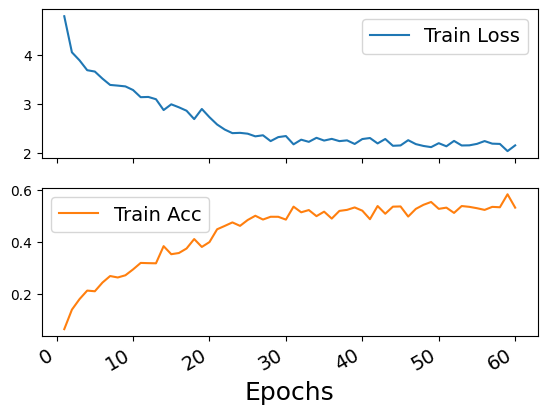

In [105]:
ax = pd.DataFrame(trn_metrics).T[['Train Loss', 'Train Acc']].plot(subplots=True, layout=(2, 1))
plt.xlabel('Epochs', fontsize=18)
plt.xticks(fontsize=14);
# plt.yticks(fontsize=14);
# ax[0, 0].tick_params(grid_markersize=14)
plt.legend(fontsize=14)
ax[0, 0].legend(fontsize=14)
plt.savefig(f'plots/tin_trn_loss_acc_stage2.png', bbox_inches='tight')

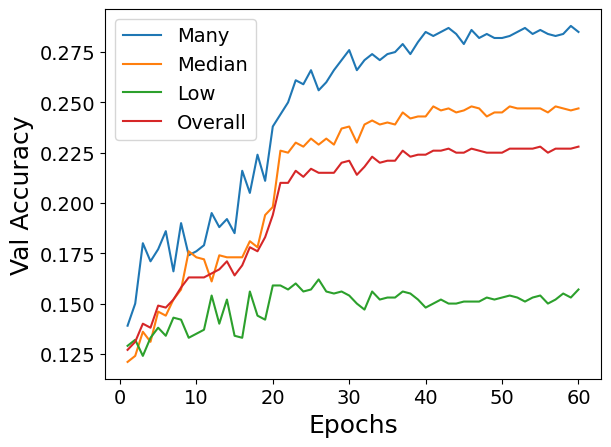

In [106]:
pd.DataFrame(val_metrics).T.plot()
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Val Accuracy', fontsize=18)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.legend(fontsize=14)
plt.savefig(f'plots/tin_val_acc_stage2.png', bbox_inches='tight')

In [10]:
pd.DataFrame(val_metrics)

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
many,0.402,0.417,0.425,0.442,0.403,0.426,0.450,0.438,0.450,0.454,...,0.475,0.478,0.479,0.480,0.477,0.480,0.478,0.479,0.479,0.477
median,0.052,0.123,0.148,0.187,0.163,0.185,0.206,0.197,0.211,0.211,...,0.260,0.260,0.261,0.263,0.262,0.259,0.263,0.261,0.266,0.262
low,0.000,0.001,0.006,0.014,0.016,0.024,0.023,0.024,0.048,0.034,...,0.066,0.067,0.066,0.067,0.067,0.068,0.070,0.070,0.069,0.067
overall,0.167,0.204,0.218,0.243,0.218,0.238,0.255,0.248,0.263,0.261,...,0.297,0.298,0.298,0.300,0.298,0.299,0.300,0.299,0.302,0.298


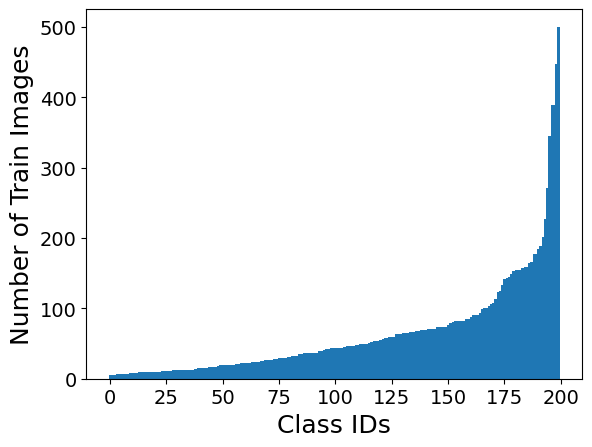

In [131]:
plt.bar(np.arange(samples.shape[0]), samples.sort().values, width=1.0)
plt.xlabel('Class IDs', fontsize=18)
plt.ylabel('Number of Train Images', fontsize=18)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.savefig(f'plots/TinyImageNet_LT/trn_dist.png', bbox_inches='tight')

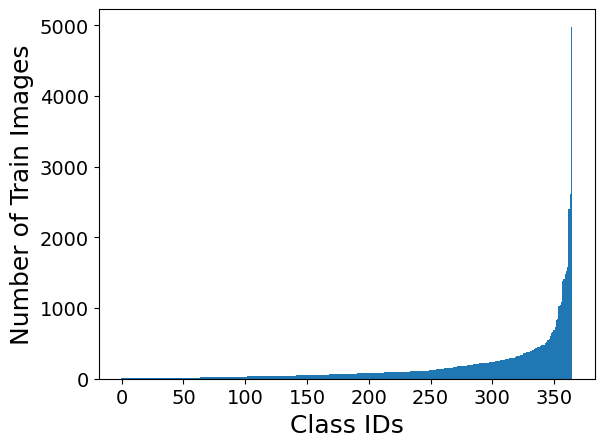

In [135]:
plt.bar(np.arange(len(mydict)), torch.LongTensor([len(x) for x in mydict.values()]).sort().values, width=1.0)
plt.xlabel('Class IDs', fontsize=18)
plt.ylabel('Number of Train Images', fontsize=18)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.savefig(f'plots/Places_LT/trn_dist.png', bbox_inches='tight')

In [8]:
state_dict = torch.load('logs/Places_LT/meta_embedding/final_model_checkpoint.pth', map_location='cpu')

In [9]:
centroids = state_dict['centroids']

In [95]:
state_dict['state_dict_best']['feat_model'].keys()

odict_keys(['module.conv1.weight', 'module.bn1.weight', 'module.bn1.bias', 'module.bn1.running_mean', 'module.bn1.running_var', 'module.bn1.num_batches_tracked', 'module.layer1.0.conv1.weight', 'module.layer1.0.bn1.weight', 'module.layer1.0.bn1.bias', 'module.layer1.0.bn1.running_mean', 'module.layer1.0.bn1.running_var', 'module.layer1.0.bn1.num_batches_tracked', 'module.layer1.0.conv2.weight', 'module.layer1.0.bn2.weight', 'module.layer1.0.bn2.bias', 'module.layer1.0.bn2.running_mean', 'module.layer1.0.bn2.running_var', 'module.layer1.0.bn2.num_batches_tracked', 'module.layer1.0.conv3.weight', 'module.layer1.0.bn3.weight', 'module.layer1.0.bn3.bias', 'module.layer1.0.bn3.running_mean', 'module.layer1.0.bn3.running_var', 'module.layer1.0.bn3.num_batches_tracked', 'module.layer1.0.downsample.0.weight', 'module.layer1.0.downsample.1.weight', 'module.layer1.0.downsample.1.bias', 'module.layer1.0.downsample.1.running_mean', 'module.layer1.0.downsample.1.running_var', 'module.layer1.0.downs

In [4]:
Y = {}
nnz = np.zeros(365).astype(int)
with open(f'data/Places_LT/Places_LT_train.txt') as f:
    for line in f:
        fname, label = line.split()
        Y[int(label)] = fname.split('/')[2]
        nnz[int(label)] += 1

In [5]:
nnz

array([ 219,   20,  115,   86,  229,   33,   25, 4980,  108, 2612,   33,
         39, 2400,   87,   12,  225,   41,   98,  191, 1582,   37,   78,
         48,    7, 1530,   56,   93,   84,   18,  183,  155,   72,   92,
         78,   10,  120,   22,    6,  143,   98,  195,   36, 1487,   93,
         73, 1406,    8,   40, 1380,  138,   11,   14, 1085,   43,   59,
         20,    6,  129,  103,   98,   46,   41, 1036,   82,   14,   23,
       1023,  841,    8,   91,   20,   30,   19,   34,   44,   11,  198,
        129,  135,  132,   29,  830,  725,   11,  689,   88,  668,   48,
          5,   38,  643,  605,   71,    6,  566,   72,   34,  547,   54,
         72,    6,   33,   36,   97,   76,   78,  521,   97,  116,  157,
        499,    8,   99,   74,   24,   62,   28,  128,  176,   72,   87,
        482,  148,   86,   40,  147,    5,  108,    6,    8,   35,   24,
        480,   32,  140,    7,   84,    6,   46,   22,  104,   85,  118,
         59,   72,   36,   34,   80,   33,  100,  4

In [19]:
from nns import exact_search
from resources import get_text, vis_point, _c

In [10]:
es = exact_search({'data': centroids.numpy(), 'query': centroids.numpy(), 'K': 10, 'metric': 'cosine'})
nns = es.getnns_gpu()

100%|██████████| 1/1 [00:00<00:00, 52.92it/s]

Total time, time per point : 0.02s, 0.0609 ms/pt


In [20]:
def vis_point(x, text, spmat, true_mat=None, sep='', K=-1, expand=False):
    if K == -1: K = spmat[x].nnz
    if true_mat is None: true_mat = tst_X_Y
        
    sorted_inds = spmat[x].indices[np.argsort(-spmat[x].data)][:K]
    print(f'x[{x}]: {_c(text[x], attr="bold")}\n')
    for i, ind in enumerate(sorted_inds):
        myattr = ""
        if true_mat[x, ind] > 0.1: myattr="yellow"
        print(f'{i+1}) {_c(Y[ind], attr=myattr)} [{ind}] ({"%.4f"%spmat[x, ind]}, {nnz[ind]})')
        if expand:
            for j, trn_ind in enumerate(trn_Y_X[ind].indices[:10]):
                print(f'\t{j+1}) {_c(trnX[trn_ind], attr="green")} [{trn_ind}] ({trnx_nnz[trn_ind]})')
        print(sep)


In [23]:
ind = np.random.randint(365)
print(Y[ind])
vis_point(ind, Y, nns, true_mat=nns, )

shoe_shop
x[300]: shoe_shop

1) shoe_shop [300] (1.0000, 11)

2) toyshop [335] (0.9431, 17)

3) gift_shop [162] (0.9384, 20)

4) department_store [115] (0.9358, 62)

5) ice_cream_parlor [185] (0.9282, 20)

6) clothing_store [96] (0.9272, 34)

7) pantry [253] (0.9156, 29)

8) flea_market [146] (0.9154, 34)

9) pet_shop [261] (0.9128, 9)

10) candy_store [80] (0.9084, 29)



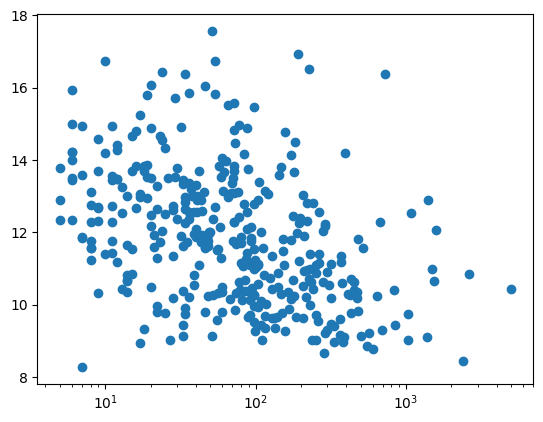

In [128]:
plt.scatter(nnz, np.linalg.norm(centroids, axis=1))
plt.xscale('log')